# Question to be answered:

- Is the accuracy of model/human significantly better? In both force and mass questions?
- Is the distribution of responses significantly different?

In [4]:
import isaac.constants
isaac.constants.TQDM_DISABLE = True

from torch import nn
from isaac.utils import get_cuda_device_if_available
import joblib

from isaac.dataset import read_dataset, prepare_dataset
from isaac.models import MultiBranchModel
from isaac.constants import BASIC_TRAINING_COLS, MASS_CLASS_COLS, FORCE_CLASS_COLS
from isaac.evaluation import evaluate_saved_model
from isaac.statistical_tests import z_test
from isaac.visualization import plot_confusion_matrix

from scipy.stats import ttest_ind, ttest_rel, f_oneway

import torch
import glob
from torch.autograd import Variable
import numpy as np
import pandas as pd
from tqdm import tqdm

In [5]:
device = get_cuda_device_if_available()
print(device)

cuda:0


In [6]:
normalise_data = True
scaler_path = "scalers_js/passive_dual_scaler.sk"
network_dims = (len(BASIC_TRAINING_COLS), 25, 3, 0.5)
dataset_path = "../new_exp_data/exp7_passive.h5"
class_columns = [list(MASS_CLASS_COLS), list(FORCE_CLASS_COLS)]
multiclass = True
seq_end = 2700
step_size = 3
N_MODELS = 25


def get_question_accuracy_for_group_of_models(question_type):    
    model_paths = tqdm(sorted(glob.glob("models/train_25_mb_with_js_data/best_"+question_type+"_model_seed_*.pt")))

    accuracies, predicted = evaluate_saved_model(model_paths, network_dims, dataset_path, 
                                                 training_columns=BASIC_TRAINING_COLS, class_columns=class_columns, 
                                                 step_size=step_size, seq_end=seq_end, scaler_path=scaler_path,
                                                 arch=MultiBranchModel, multiclass=multiclass, trials=None)
    
    if question_type == "mass":
        question_index = 0
    else:
        question_index = 1

    accuracies = np.stack(accuracies)[:, question_index]
    
    predicted = [x[:, question_index].numpy() for x in predicted]

    return accuracies, predicted

In [7]:
def get_participant_accuracy_filtering_by_answer(passive_responses, answer_column, question_type_answer, filter_by_class):
    
    passive_responses = passive_responses.copy().query(question_type_answer+" == "+filter_by_class)
    return passive_responses[answer_column]

# T-test for MASS questions

## Load model's predictions

In [8]:
print("MASS")
question_type = "mass"
group_mass_acc, group_mass_prediction = get_question_accuracy_for_group_of_models(question_type)
     
print("\nFORCE")
question_type = "force"
group_force_acc, group_force_prediction = get_question_accuracy_for_group_of_models(question_type)

  0%|          | 0/25 [00:00<?, ?it/s]

MASS


  0%|          | 0/25 [00:00<?, ?it/s]


FORCE


100%|██████████| 25/25 [00:13<00:00,  1.87it/s]


In [9]:
group_mass_prediction = np.array(group_mass_prediction)
group_force_prediction = np.array(group_force_prediction)

In [10]:
answers = []
for question_i in range(group_mass_prediction.shape[1]):
    
    mass_predictions = list(group_mass_prediction[:, question_i])
    question_mass_answers = [(key, mass_predictions.count(key)) for key in range(3)]
    question_mass_counts = [x[1] for x in question_mass_answers]
    
    sorted_mass_answers = sorted(question_mass_answers, key=lambda x: x[1], reverse=True)
    sorted_mass_answers = np.hstack(sorted_mass_answers)
    question_mass_answers = np.concatenate((sorted_mass_answers, question_mass_counts))
        
    force_predictions = list(group_force_prediction[:, question_i])
    question_force_answers = [(key, force_predictions.count(key)) for key in range(3)]
    question_force_counts = [x[1] for x in question_force_answers]
    
    sorted_force_answers = sorted(question_force_answers, key=lambda x: x[1], reverse=True)
    sorted_force_answers = np.hstack(sorted_force_answers)
    question_force_answers = np.concatenate((sorted_force_answers, question_force_counts))
    
    answers.append(np.hstack((question_mass_answers, question_force_answers)))
    

model_answers_df = pd.DataFrame(data=answers, 
                                columns=["models_first_mass_resp", "models_first_mass_count", 
                                         "models_second_mass_resp", "models_second_mass_count",
                                         "models_third_mass_resp", "models_third_mass_count",
                                         "models_chose_A", "models_chose_B", "models_chose_same",
                                         "models_first_rel_resp", "models_first_rel_count", 
                                         "models_second_rel_resp", "models_second_rel_count",
                                         "models_third_rel_resp", "models_third_rel_count",
                                         "models_chose_attract", "models_chose_none", "models_chose_repel",
                                         ])

mass_answer_id_to_str = lambda x: MASS_CLASS_COLS[int(x)]
rel_answer_id_to_str = lambda x: FORCE_CLASS_COLS[int(x)]

model_answers_df.models_first_mass_resp = model_answers_df.models_first_mass_resp.apply(mass_answer_id_to_str)
model_answers_df.models_second_mass_resp = model_answers_df.models_second_mass_resp.apply(mass_answer_id_to_str)
model_answers_df.models_third_mass_resp = model_answers_df.models_third_mass_resp.apply(mass_answer_id_to_str)

model_answers_df.models_first_rel_resp = model_answers_df.models_first_rel_resp.apply(rel_answer_id_to_str)
model_answers_df.models_second_rel_resp = model_answers_df.models_second_rel_resp.apply(rel_answer_id_to_str)
model_answers_df.models_third_rel_resp = model_answers_df.models_third_rel_resp.apply(rel_answer_id_to_str)

In [11]:
model_answers_df.head()

,models_first_mass_resp,models_first_mass_count,models_second_mass_resp,models_second_mass_count,models_third_mass_resp,models_third_mass_count,models_chose_A,models_chose_B,models_chose_same,models_first_rel_resp,models_first_rel_count,models_second_rel_resp,models_second_rel_count,models_third_rel_resp,models_third_rel_count,models_chose_attract,models_chose_none,models_chose_repel
0,A,15,same,10,B,0,15,0,10,attract,15,none,10,repel,0,15,10,0
1,A,13,same,11,B,1,13,1,11,attract,17,none,8,repel,0,17,8,0
2,B,22,same,3,A,0,0,22,3,attract,25,none,0,repel,0,25,0,0
3,A,13,same,12,B,0,13,0,12,none,16,repel,7,attract,2,2,16,7
4,A,13,same,10,B,2,13,2,10,none,20,repel,4,attract,1,1,20,4


In [12]:
import json

In [13]:
condition_world_variant = []
world_id = []

for condition_id in range(1, 5):
    filename = "../new_exp_data/physics_data%d.json" % condition_id
    fd = open(filename)
    sim_data = json.load(fd)
    
    for sim in sim_data:
        if sim["practice"]:
            continue
        condition_world_variant.append(sim["condition_world_variant"])
        world_id.append(sim["world_id"])

In [14]:
model_answers_df["condition_world_variant"] = condition_world_variant
model_answers_df["world_id"] = world_id

In [15]:
model_answers_df.head()

,models_first_mass_resp,models_first_mass_count,models_second_mass_resp,models_second_mass_count,models_third_mass_resp,models_third_mass_count,models_chose_A,models_chose_B,models_chose_same,models_first_rel_resp,models_first_rel_count,models_second_rel_resp,models_second_rel_count,models_third_rel_resp,models_third_rel_count,models_chose_attract,models_chose_none,models_chose_repel,condition_world_variant,world_id
0,A,15,same,10,B,0,15,0,10,attract,15,none,10,repel,0,15,10,0,1,481
1,A,13,same,11,B,1,13,1,11,attract,17,none,8,repel,0,17,8,0,1,856
2,B,22,same,3,A,0,0,22,3,attract,25,none,0,repel,0,25,0,0,1,1819
3,A,13,same,12,B,0,13,0,12,none,16,repel,7,attract,2,2,16,7,1,566
4,A,13,same,10,B,2,13,2,10,none,20,repel,4,attract,1,1,20,4,1,821


## Load human results

In [16]:
from rpy2.robjects import r, pandas2ri
pandas2ri.activate()

In [17]:
rdata_path = "../new_exp_data/e7_passive_io_rtheta.rdata"
r['load'](rdata_path)

responses = r["tw"].query("practice == 0")

# Percentage of participants that get an answer right

In [18]:
passive_responses = []

for name, df in responses.groupby(["cond_worldvar", "world_id", "true_mass", "true_rel", "post_ent_mass.rtheta", "post_ent_rel.rtheta"]):
    response = [name[0], name[1], name[2], name[3], name[4], name[5]]

    value_counts = df.resp_rel.value_counts().sort_index().sort_values(ascending=False)
    for i in range(len(value_counts)):
        answer = value_counts.index[i]
        response.append(answer)
        if answer == name[3]:
            got_it_right = value_counts[i]
            
    response.append(got_it_right / value_counts.sum())
    response.append(value_counts["attract"])
    response.append(value_counts["none"])
    response.append(value_counts["repel"])
    
    value_counts = df.resp_mass.value_counts().sort_index().sort_values(ascending=False)
    
    for i in range(len(value_counts)):
        answer = value_counts.index[i]
        response.append(answer)
        if answer == name[2]:
            got_it_right = value_counts[i]
            
    response.append(got_it_right / value_counts.sum())
    response.append(value_counts["A"])
    response.append(value_counts["B"])
    response.append(value_counts["same"])    
        
    passive_responses.append(response)

In [19]:
passive_responses = pd.DataFrame(data=passive_responses, 
                                 columns=["cond_worldvar", "world_id", "true_mass", "true_rel",  "post_ent_mass.rtheta", "post_ent_rel.rtheta",
                                          "humans_first_resp_rel", "humans_second_resp_rel", "humans_third_resp_rel", 
                                          "got_rel_right", "humans_chose_attract", "humans_chose_none", "humans_chose_repel",
                                          "humans_first_resp_mass", "humans_second_resp_mass", "humans_third_resp_mass",
                                          "got_mass_right", "humans_chose_A", "humans_chose_B", "humans_chose_same"])

In [20]:
passive_responses.head()

,cond_worldvar,world_id,true_mass,true_rel,post_ent_mass.rtheta,post_ent_rel.rtheta,humans_first_resp_rel,humans_second_resp_rel,humans_third_resp_rel,got_rel_right,humans_chose_attract,humans_chose_none,humans_chose_repel,humans_first_resp_mass,humans_second_resp_mass,humans_third_resp_mass,got_mass_right,humans_chose_A,humans_chose_B,humans_chose_same
0,1,1218,A,repel,0.000827,1.402287,repel,attract,none,0.76,4,2,19,A,same,B,0.52,13,5,7
1,1,1736,B,none,0.022527,1.413136,repel,none,attract,0.40,2,10,13,B,same,A,0.52,4,13,8
2,1,1758,B,repel,0.049913,1.555458,repel,attract,none,0.44,8,6,11,B,same,A,0.72,1,18,6
3,1,1819,B,attract,0.243940,0.924914,attract,repel,none,0.64,16,1,8,B,same,A,0.60,5,15,5
4,1,438,same,repel,0.051500,1.305047,repel,none,attract,0.56,4,7,14,same,B,A,0.36,7,9,9


In [21]:
passive_responses["cond_worldvar"] = passive_responses["cond_worldvar"].astype("int64")
passive_responses["world_id"] = passive_responses["world_id"].astype("int64")

passive_responses = passive_responses.merge(model_answers_df, left_on=["cond_worldvar", "world_id"], right_on=["condition_world_variant", "world_id"])

# Percentage of models that get an answer right

In [75]:
models_that_got_mass_question_right = []

for i, answer in enumerate(passive_responses.true_mass):
    if passive_responses.models_first_mass_resp.iloc[i] == answer:
        models_that_got_mass_question_right.append(passive_responses.models_first_mass_count.iloc[i])
    elif passive_responses.models_second_mass_resp.iloc[i] == answer:
        models_that_got_mass_question_right.append(passive_responses.models_second_mass_count.iloc[i])
    elif passive_responses.models_third_mass_resp.iloc[i] == answer:
        models_that_got_mass_question_right.append(passive_responses.models_third_mass_count.iloc[i])

        
models_that_got_rel_question_right = []
        
for i, answer in enumerate(passive_responses.true_rel):
    if passive_responses.models_first_rel_resp.iloc[i] == answer:
        models_that_got_rel_question_right.append(passive_responses.models_first_rel_count.iloc[i])
    elif passive_responses.models_second_rel_resp.iloc[i] == answer:
        models_that_got_rel_question_right.append(passive_responses.models_second_rel_count.iloc[i])
    elif passive_responses.models_third_rel_resp.iloc[i] == answer:
        models_that_got_rel_question_right.append(passive_responses.models_third_rel_count.iloc[i])
        

passive_responses["models_got_mass_right"] = np.array(models_that_got_mass_question_right) / N_MODELS
passive_responses["models_got_rel_right"] = np.array(models_that_got_rel_question_right) / N_MODELS

In [20]:
passive_responses.columns

Index(['cond_worldvar', 'world_id', 'true_mass', 'true_rel',
       'post_ent_mass.rtheta', 'post_ent_rel.rtheta', 'humans_first_resp_rel',
       'humans_second_resp_rel', 'humans_third_resp_rel', 'got_rel_right',
       'humans_chose_attract', 'humans_chose_none', 'humans_chose_repel',
       'humans_first_resp_mass', 'humans_second_resp_mass',
       'humans_third_resp_mass', 'got_mass_right', 'humans_chose_A',
       'humans_chose_B', 'humans_chose_same', 'models_first_mass_resp',
       'models_first_mass_count', 'models_second_mass_resp',
       'models_second_mass_count', 'models_third_mass_resp',
       'models_third_mass_count', 'models_chose_A', 'models_chose_B',
       'models_chose_same', 'models_first_rel_resp', 'models_first_rel_count',
       'models_second_rel_resp', 'models_second_rel_count',
       'models_third_rel_resp', 'models_third_rel_count',
       'models_chose_attract', 'models_chose_none', 'models_chose_repel',
       'condition_world_variant', 'models_got_m

In [87]:
passive_responses.head()

,cond_worldvar,world_id,true_mass,true_rel,post_ent_mass.rtheta,post_ent_rel.rtheta,humans_first_resp_rel,humans_second_resp_rel,humans_third_resp_rel,got_rel_right,...,models_second_rel_resp,models_second_rel_count,models_third_rel_resp,models_third_rel_count,models_chose_attract,models_chose_none,models_chose_repel,condition_world_variant,models_got_mass_right,models_got_rel_right
0,1,1218,A,repel,0.000827,1.402287,repel,attract,none,0.760000,...,attract,3,repel,2,3,20,2,1,0.92,0.08
17,2,923,A,none,0.095797,0.035784,attract,none,repel,0.333333,...,attract,8,repel,2,8,15,2,2,0.28,0.60
18,3,1006,A,attract,0.001406,0.569638,attract,repel,none,0.800000,...,none,1,repel,0,24,1,0,3,0.36,0.96
28,4,1282,A,attract,0.035370,1.524994,attract,repel,none,0.461538,...,attract,7,repel,2,7,16,2,4,0.84,0.28
9,2,1228,A,attract,0.000253,1.174987,attract,none,repel,0.625000,...,none,8,repel,0,17,8,0,2,0.60,0.68


In [21]:
passive_responses["model_mass"] = passive_responses["models_first_mass_resp"]
passive_responses["model_relationship"] = passive_responses["models_first_rel_resp"]

In [22]:
human_mass_accuracy_list = passive_responses.got_mass_right
human_force_accuracy_list = passive_responses.got_rel_right

model_mass_accuracy_list = passive_responses.models_got_mass_right
model_force_accuracy_list = passive_responses.models_got_rel_right

# Perform t-test on overall accuracy

In [23]:
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import seaborn as sns

sns.set(font_scale=2)
sns.set_style("white")
plt.rc('font', weight='bold')

In [24]:
print(np.mean(human_mass_accuracy_list), "±", np.std(human_mass_accuracy_list))
print(np.mean(model_mass_accuracy_list), "±", np.std(model_mass_accuracy_list))

0.37839031339031337 ± 0.145973580677441
0.508888888888889 ± 0.2625703903271334


In [25]:
from sklearn.linear_model import LinearRegression
max_entropy = -np.sum([1/3, 1/3, 1/3] * np.log2([1/3, 1/3, 1/3]))

def plot_correlation(human_accuracy_list, model_accuracy_list, solutions, xlabel="RNN accuracy", savepath=None):
    
    corr, pval = spearmanr(model_accuracy_list, human_accuracy_list)
    print(pval)
    df = pd.DataFrame({"Human accuracy": human_accuracy_list, xlabel: model_accuracy_list, "solution": solutions})
    plt.figure(figsize=(8, 6))
    sns.regplot(x=xlabel, y="Human accuracy", data=df, scatter_kws={"s": 100})
    plt.title("$r_s$ = %.3f" % corr, weight="bold", size=30)
    plt.ylabel("Human accuracy", weight="bold")
    plt.xlabel(xlabel, weight="bold")
    sns.despine()
    
    if savepath is not None:
        plt.savefig(savepath, bbox_inches='tight')
    plt.show()

0.005777678267924197


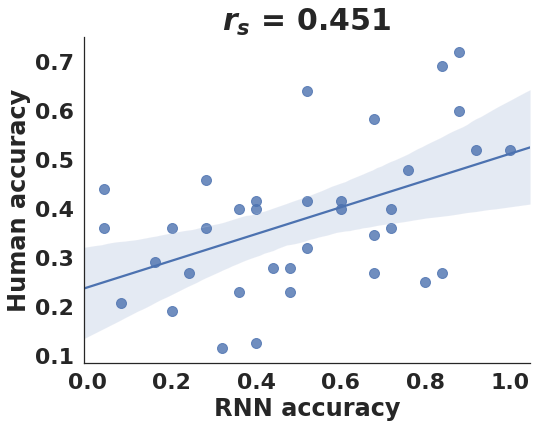

0.5333901341240859


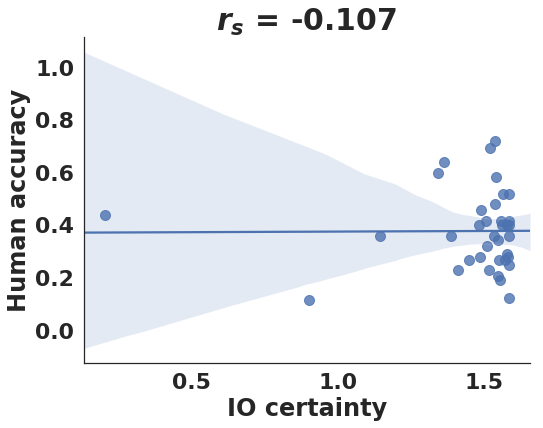

In [26]:
plot_correlation(human_mass_accuracy_list, model_mass_accuracy_list, passive_responses.true_mass,
                savepath="cogsci_images/rnn_accuracy_vs_human_accuracy_mass.pdf")
plot_correlation(human_mass_accuracy_list, -passive_responses["post_ent_mass.rtheta"] + max_entropy, passive_responses.true_mass, "IO certainty")

0.29070470656480796


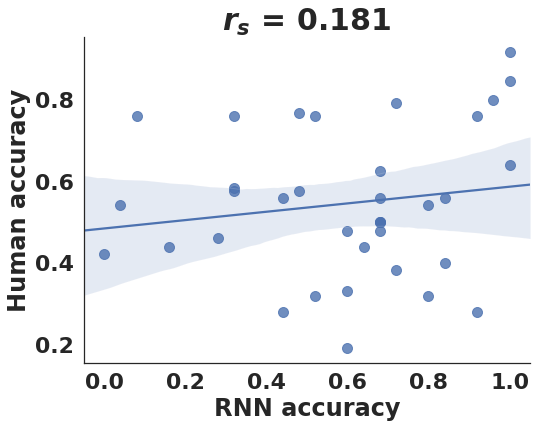

0.10444485962740473


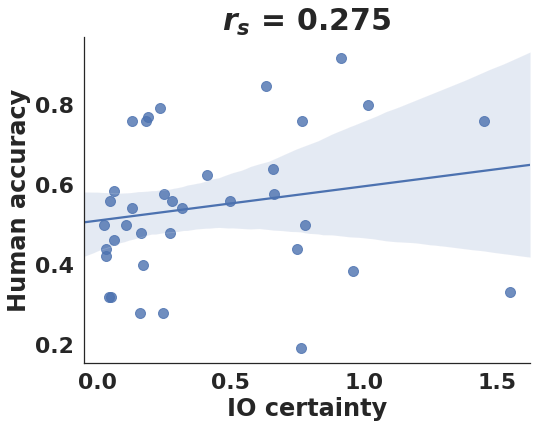

In [27]:
plot_correlation(human_force_accuracy_list, model_force_accuracy_list, 
                 passive_responses.true_rel, savepath="cogsci_images/rnn_accuracy_vs_human_accuracy_force.pdf")
plot_correlation(human_force_accuracy_list, -passive_responses["post_ent_rel.rtheta"] + max_entropy, passive_responses.true_rel, "IO certainty")

#### Is the model significantly better answering mass questions than humans?

In [28]:
ttest_rel(human_mass_accuracy_list, model_mass_accuracy_list)

Ttest_relResult(statistic=-3.3652400374634275, pvalue=0.0018672325620190308)

#### Is the model significantly better answering force questions than humans?

In [29]:
ttest_rel(human_force_accuracy_list, model_force_accuracy_list)

Ttest_relResult(statistic=-0.9742345405313715, pvalue=0.3366257154159368)

#### Is the model significantly better answering force questions than mass questions? And humans?

In [30]:
print(ttest_ind(model_mass_accuracy_list, model_force_accuracy_list))
print(ttest_ind(human_mass_accuracy_list, human_force_accuracy_list))

Ttest_indResult(statistic=-1.3585587195785374, pvalue=0.17864850524171333)
Ttest_indResult(statistic=-4.3304952743613745, pvalue=4.86608749152777e-05)


# Is the model better at predicting any force class?

In [31]:
repel_accuracy_list = get_participant_accuracy_filtering_by_answer(passive_responses, "models_got_rel_right", 
                                                                   "true_rel", "'repel'")

none_accuracy_list = get_participant_accuracy_filtering_by_answer(passive_responses, "models_got_rel_right", 
                                                                   "true_rel", "'none'")

attract_accuracy_list = get_participant_accuracy_filtering_by_answer(passive_responses, "models_got_rel_right", 
                                                                   "true_rel", "'attract'")

In [32]:
print(np.mean(repel_accuracy_list), np.std(repel_accuracy_list))
print(np.mean(none_accuracy_list), np.std(none_accuracy_list))
print(np.mean(attract_accuracy_list), np.std(attract_accuracy_list))

print()

print(ttest_ind(repel_accuracy_list, none_accuracy_list))
print(ttest_ind(repel_accuracy_list, attract_accuracy_list))
print(ttest_ind(attract_accuracy_list, none_accuracy_list))

0.45 0.2871120571019848
0.6 0.20912516188477498
0.7366666666666667 0.23062716424759874

Ttest_indResult(statistic=-1.400603757339189, pvalue=0.1752796905623199)
Ttest_indResult(statistic=-2.581713888104716, pvalue=0.017020359346155697)
Ttest_indResult(statistic=1.4559526896682922, pvalue=0.1595291945996125)


# Are humans better at predicting any force class? And compared to RNNs?

In [33]:
human_repel_accuracy_list = get_participant_accuracy_filtering_by_answer(passive_responses, "got_rel_right", 
                                                                         "true_rel", "'repel'")

human_none_accuracy_list = get_participant_accuracy_filtering_by_answer(passive_responses, "got_rel_right", 
                                                                        "true_rel", "'none'")

human_attract_accuracy_list = get_participant_accuracy_filtering_by_answer(passive_responses, "got_rel_right", 
                                                                   "true_rel", "'attract'")

print(np.mean(human_repel_accuracy_list), np.std(human_repel_accuracy_list))
print(np.mean(human_none_accuracy_list), np.std(human_none_accuracy_list))
print(np.mean(human_attract_accuracy_list), np.std(human_attract_accuracy_list))


print()

print(ttest_ind(human_repel_accuracy_list, human_none_accuracy_list))
print(ttest_ind(human_repel_accuracy_list, human_attract_accuracy_list))
print(ttest_ind(human_attract_accuracy_list, human_none_accuracy_list))

0.5727350427350427 0.13531888148325485
0.38777777777777783 0.10039803172690473
0.6781623931623932 0.14894697893841963

Ttest_indResult(statistic=3.640639395027706, pvalue=0.0014428896714880582)
Ttest_indResult(statistic=-1.7375664164447775, pvalue=0.09626821719795242)
Ttest_indResult(statistic=5.361722481943239, pvalue=2.204329106568638e-05)


In [34]:
print(ttest_rel(repel_accuracy_list, human_repel_accuracy_list))
print(ttest_rel(none_accuracy_list, human_none_accuracy_list))
print(ttest_rel(attract_accuracy_list, human_attract_accuracy_list))

Ttest_relResult(statistic=-1.105899541031833, pvalue=0.2923701116411201)
Ttest_relResult(statistic=3.1552886091860928, pvalue=0.009155481235687034)
Ttest_relResult(statistic=1.1650627137234846, pvalue=0.2686370821132175)


# Is the model better at predicting any mass class?

In [35]:
a_accuracy_list = get_participant_accuracy_filtering_by_answer(passive_responses, "models_got_mass_right", 
                                                                   "true_mass", "'A'")

same_accuracy_list = get_participant_accuracy_filtering_by_answer(passive_responses, "models_got_mass_right", 
                                                                   "true_mass", "'same'")

b_accuracy_list = get_participant_accuracy_filtering_by_answer(passive_responses, "models_got_mass_right", 
                                                                   "true_mass", "'B'")

In [36]:
print(np.mean(a_accuracy_list), np.std(a_accuracy_list))
print(np.mean(same_accuracy_list), np.std(same_accuracy_list))
print(np.mean(b_accuracy_list), np.std(b_accuracy_list))

print()

print(ttest_ind(a_accuracy_list, same_accuracy_list))
print(ttest_ind(a_accuracy_list, b_accuracy_list))
print(ttest_ind(b_accuracy_list, same_accuracy_list))

0.47666666666666674 0.2620220516589311
0.38333333333333336 0.22830291768223684
0.6666666666666666 0.21060758665241755

Ttest_indResult(statistic=0.8907167141967209, pvalue=0.3827190355700524)
Ttest_indResult(statistic=-1.8745169469195684, pvalue=0.07419925055395671)
Ttest_indResult(statistic=3.025383038787512, pvalue=0.00621745872661447)


# Are humans better at predicting any mass class? And compared to RNNs?

In [37]:
human_a_accuracy_list = get_participant_accuracy_filtering_by_answer(passive_responses, "got_mass_right", 
                                                                     "true_mass", "'A'")

human_same_accuracy_list = get_participant_accuracy_filtering_by_answer(passive_responses, "got_mass_right", 
                                                                        "true_mass", "'same'")

human_b_accuracy_list = get_participant_accuracy_filtering_by_answer(passive_responses, "got_mass_right", 
                                                                     "true_mass", "'B'")

print(np.mean(human_a_accuracy_list), np.std(human_a_accuracy_list))
print(np.mean(human_same_accuracy_list), np.std(human_same_accuracy_list))
print(np.mean(human_b_accuracy_list), np.std(human_b_accuracy_list))

print()

print()

print(ttest_ind(human_a_accuracy_list, human_same_accuracy_list))
print(ttest_ind(human_a_accuracy_list, human_b_accuracy_list))
print(ttest_ind(human_b_accuracy_list, human_same_accuracy_list))

0.4100427350427351 0.14185875067409623
0.30391025641025643 0.11751739115262044
0.42121794871794865 0.14699406576210686


Ttest_indResult(statistic=1.9108454864102784, pvalue=0.0691424586904233)
Ttest_indResult(statistic=-0.1814353668752333, pvalue=0.8576870862868097)
Ttest_indResult(statistic=2.0673466990693723, pvalue=0.050664413609717754)


In [38]:
print(ttest_rel(a_accuracy_list, human_a_accuracy_list))
print(ttest_rel(same_accuracy_list, human_same_accuracy_list))
print(ttest_rel(b_accuracy_list, human_b_accuracy_list))

Ttest_relResult(statistic=0.9681227182139432, pvalue=0.3537875863049561)
Ttest_relResult(statistic=1.1247809439416705, pvalue=0.28462656804856973)
Ttest_relResult(statistic=4.619706885979588, pvalue=0.0007407264734344853)


# Do model's correct answers correspond to examples that a higher percentage of humans guess?

In [39]:
passive_responses["model_mass_correct_guesses"] = (passive_responses["model_mass"] == passive_responses["true_mass"])
passive_responses["model_force_correct_guesses"] = (passive_responses["model_relationship"] == passive_responses["true_rel"])

In [40]:
passive_responses["corRel"] = (passive_responses["humans_first_resp_rel"] == passive_responses["true_rel"])
passive_responses["corMass"] = (passive_responses["humans_first_resp_mass"] == passive_responses["true_mass"])

In [41]:
mass_coincidence = (passive_responses["humans_first_resp_mass"] == passive_responses["model_mass"]).mean()
force_coincidence = (passive_responses["humans_first_resp_rel"] == passive_responses["model_relationship"]).mean()

print(mass_coincidence)
print(force_coincidence)

# FLAG

0.5555555555555556
0.5555555555555556


### Mass responses

In [42]:
post_mass_correct_guesses = passive_responses.query("model_mass_correct_guesses")["got_mass_right"]
post_mass_wrong_guesses = passive_responses.query("not model_mass_correct_guesses")["got_mass_right"]

f_oneway(post_mass_correct_guesses, post_mass_wrong_guesses)

F_onewayResult(statistic=14.39595315726459, pvalue=0.0005816314444849311)

In [43]:
len(post_mass_correct_guesses), len(post_mass_wrong_guesses)

(19, 17)

### Force responses

In [44]:
post_force_correct_guesses = passive_responses.query("model_force_correct_guesses")['got_rel_right']
post_force_wrong_guesses = passive_responses.query("not model_force_correct_guesses")['got_rel_right']

f_oneway(post_force_correct_guesses, post_force_wrong_guesses)

F_onewayResult(statistic=0.023993851059373437, pvalue=0.8778164712009029)

In [45]:
len(post_force_correct_guesses), len(post_force_wrong_guesses)

(26, 10)

# Are %RNNs and %participants getting a question correct correlated?

In [46]:
passive_responses.head()

,cond_worldvar,world_id,true_mass,true_rel,post_ent_mass.rtheta,post_ent_rel.rtheta,humans_first_resp_rel,humans_second_resp_rel,humans_third_resp_rel,got_rel_right,...,models_chose_repel,condition_world_variant,models_got_mass_right,models_got_rel_right,model_mass,model_relationship,model_mass_correct_guesses,model_force_correct_guesses,corRel,corMass
0,1,1218,A,repel,0.000827,1.402287,repel,attract,none,0.76,...,2,1,0.92,0.08,A,none,True,False,True,True
1,1,1736,B,none,0.022527,1.413136,repel,none,attract,0.40,...,3,1,1.00,0.84,B,none,True,True,False,True
2,1,1758,B,repel,0.049913,1.555458,repel,attract,none,0.44,...,4,1,0.88,0.16,B,none,True,False,True,True
3,1,1819,B,attract,0.243940,0.924914,attract,repel,none,0.64,...,0,1,0.88,1.00,B,attract,True,True,True,True
4,1,438,same,repel,0.051500,1.305047,repel,none,attract,0.56,...,11,1,0.72,0.44,same,none,True,False,True,True


In [47]:
import matplotlib.pyplot as plt

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

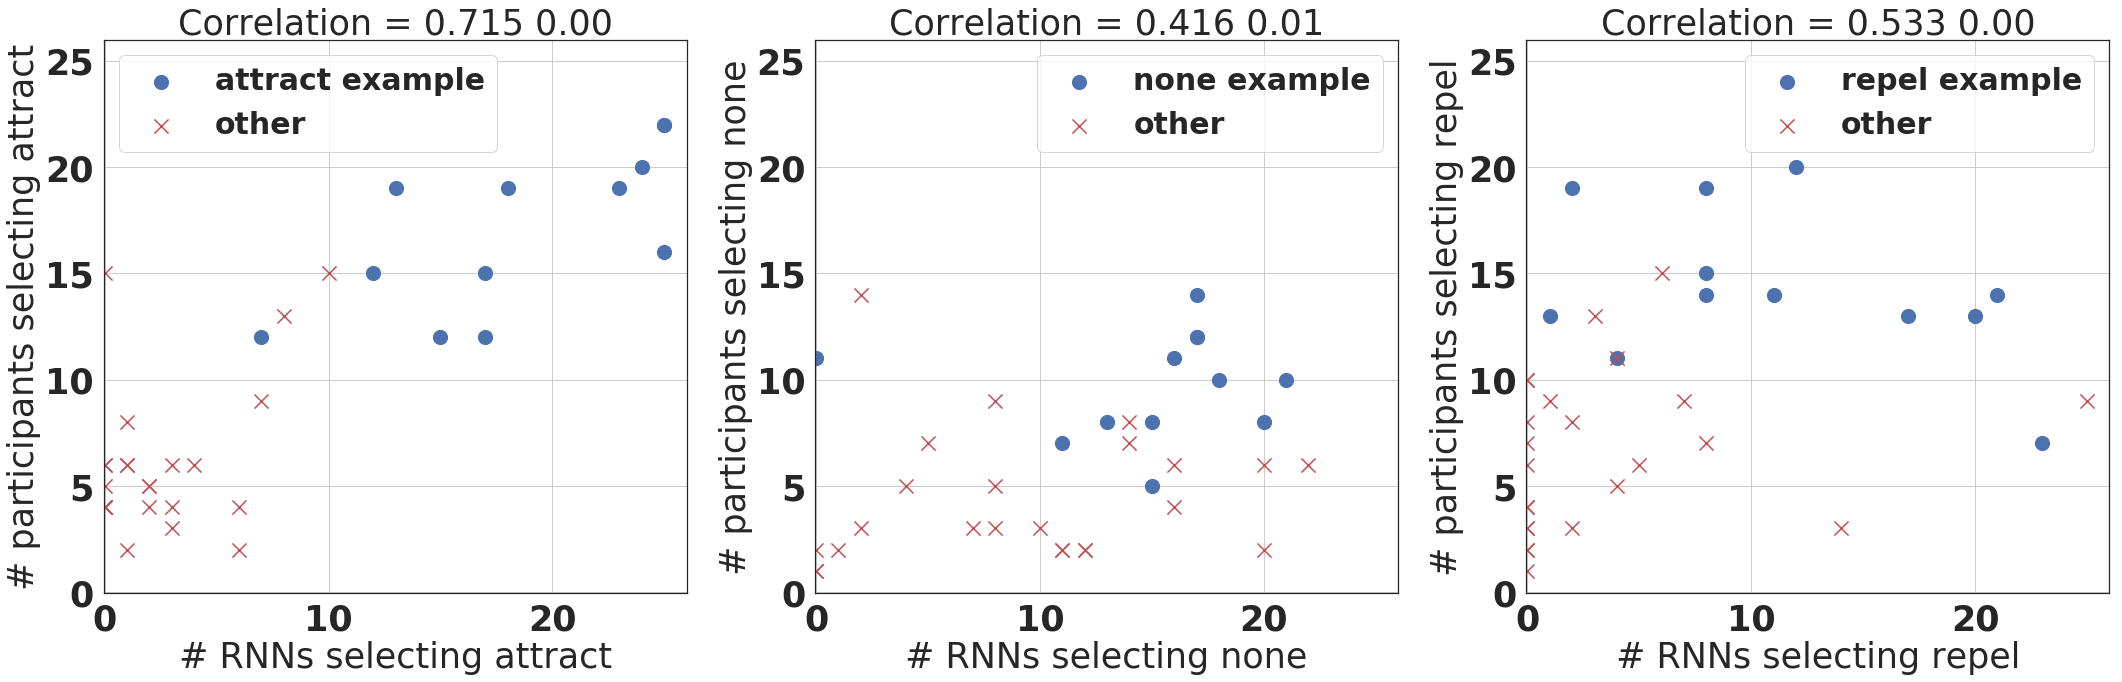

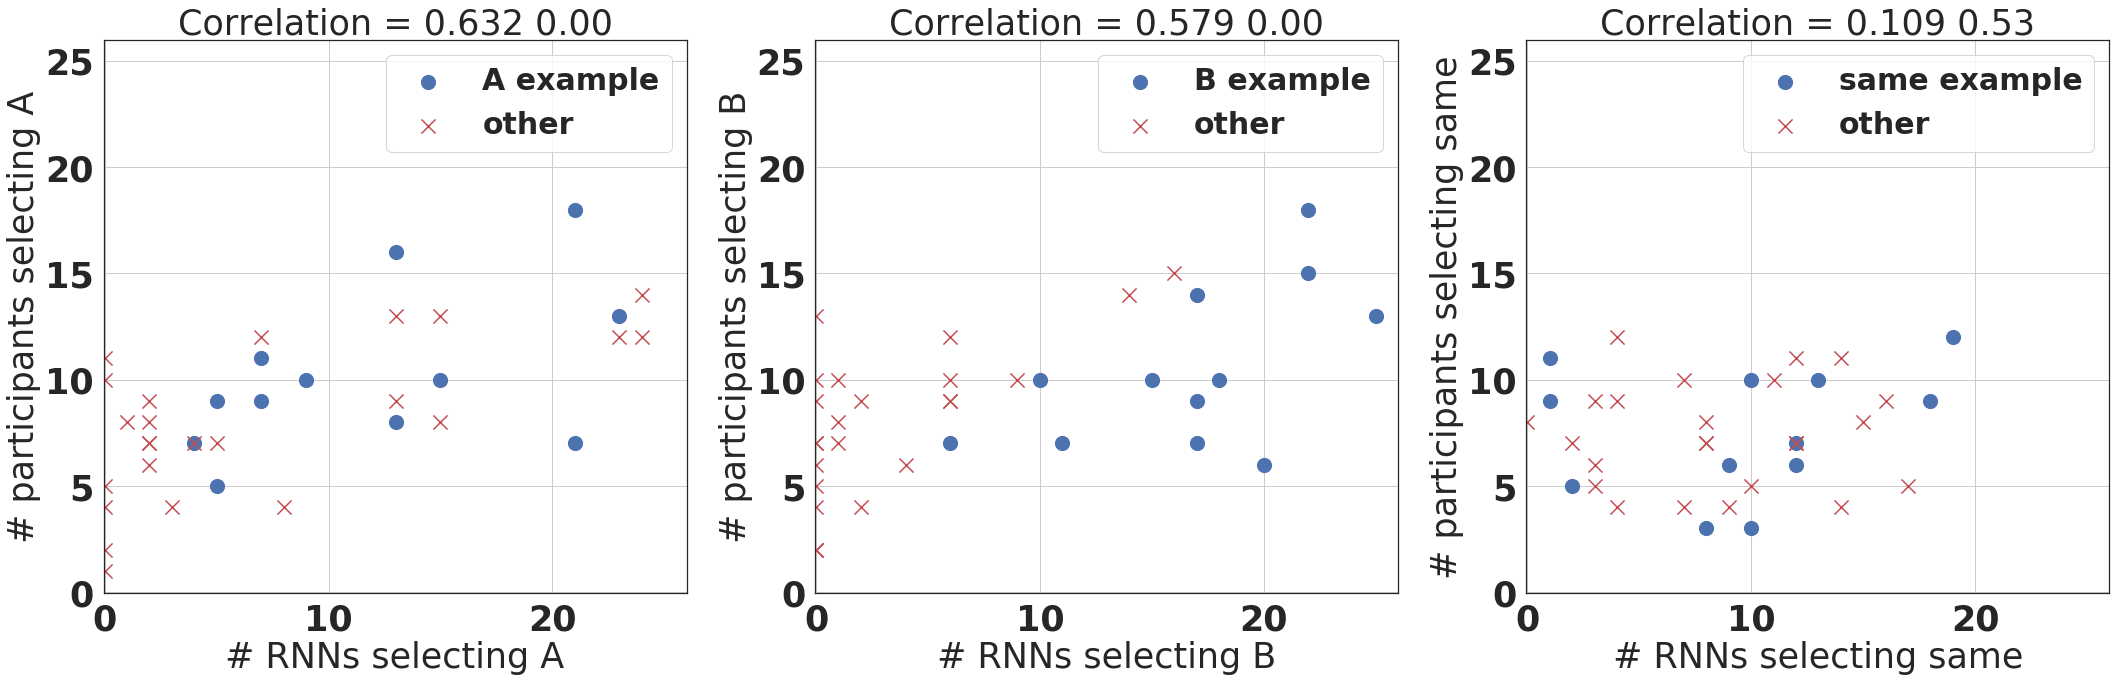

In [48]:
def plot_correlation(class_columns, true_class):
    
    f, axes = plt.subplots(1, 3, figsize=(30, 10))
    c = ["r", "y", "b"]
    

    
    for i, cl in enumerate(class_columns):
        corr_coef, pval = spearmanr(passive_responses["humans_chose_"+cl], passive_responses["models_chose_"+cl])        
        is_example_correct = (passive_responses[true_class] == cl)
        
        passive_responses[is_example_correct].plot(kind="scatter", x="models_chose_"+cl, y="humans_chose_"+cl, 
                                                   marker="o", ax=axes[i], label=cl+" example", s=200)
        passive_responses[~is_example_correct].plot(kind="scatter", x="models_chose_"+cl, y="humans_chose_"+cl, c="r", 
                                                    marker="x", ax=axes[i], label="other", s=200)

        axes[i].set_title("Correlation = %.3f %.2f" % (corr_coef, pval), fontsize=35)
        axes[i].set_xlabel("# RNNs selecting "+cl, fontsize=35)
        axes[i].set_ylabel("# participants selecting "+cl, fontsize=35)
        axes[i].legend(fontsize=30)
        axes[i].set_xlim((-0.05, 26))
        axes[i].set_ylim((-0.05, 26))
        axes[i].tick_params(axis='both', which='major', labelsize=35)
        axes[i].grid()

    plt.tight_layout()
    plt.savefig("cogsci_images/"+true_class.split("_")[1]+"_percentages_correlation.pdf")
    plt.savefig("cogsci_images/"+true_class.split("_")[1]+"_percentages_correlation.jpg")

plot_correlation(FORCE_CLASS_COLS, "true_rel")    
plot_correlation(MASS_CLASS_COLS, "true_mass")

# CONFUSION MATRICES

In [49]:
N_PARTICIPANTS = 25
mass_solutions = []
force_solutions = []
human_mass_answers = []
human_force_answers = []
model_mass_answers = []
model_force_answers = []

for row in range(passive_responses.shape[0]):
    mass_solution = passive_responses.iloc[row].true_mass
    mass_solutions.extend([mass_solution for _ in range(N_PARTICIPANTS)])
    force_solution = passive_responses.iloc[row].true_rel
    force_solutions.extend([force_solution for _ in range(N_PARTICIPANTS)])
    
    human_mass_answers.extend(["A" for _ in range(passive_responses.iloc[row].humans_chose_A)])
    human_mass_answers.extend(["B" for _ in range(passive_responses.iloc[row].humans_chose_B)])
    human_mass_answers.extend(["same" for _ in range(passive_responses.iloc[row].humans_chose_same)])
    human_force_answers.extend(["attract" for _ in range(passive_responses.iloc[row].humans_chose_attract)])
    human_force_answers.extend(["repel" for _ in range(passive_responses.iloc[row].humans_chose_repel)])
    human_force_answers.extend(["none" for _ in range(passive_responses.iloc[row].humans_chose_none)])
    
    model_mass_answers.extend(["A" for _ in range(passive_responses.iloc[row].models_chose_A)])
    model_mass_answers.extend(["B" for _ in range(passive_responses.iloc[row].models_chose_B)])
    model_mass_answers.extend(["same" for _ in range(passive_responses.iloc[row].models_chose_same)])
    model_force_answers.extend(["attract" for _ in range(passive_responses.iloc[row].models_chose_attract)])
    model_force_answers.extend(["repel" for _ in range(passive_responses.iloc[row].models_chose_repel)])
    model_force_answers.extend(["none" for _ in range(passive_responses.iloc[row].models_chose_none)])

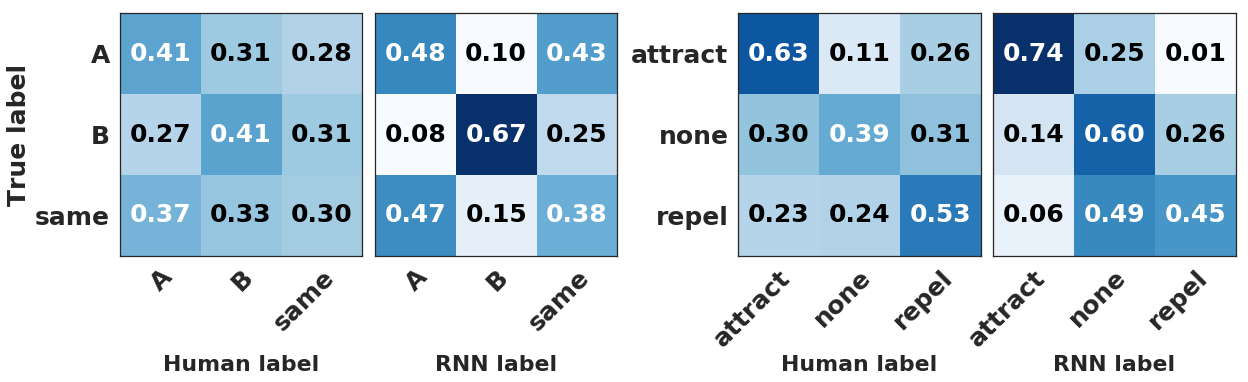

In [50]:
fig, axis = plt.subplots(1, 4, figsize=(20, 9))

ax = plot_confusion_matrix(mass_solutions, human_mass_answers, MASS_CLASS_COLS, ax=axis[0], normalize=True, vmin=0.10, vmax=0.67)
ax.set_ylabel("True label", fontsize=25, fontweight='bold')
ax.set_xlabel("Human label", fontsize=22, fontweight='bold')
ax.tick_params(axis="both", labelsize=25)
ax.set_xticklabels(MASS_CLASS_COLS, fontweight='bold')
ax.set_yticklabels(MASS_CLASS_COLS, fontweight='bold')

ax = plot_confusion_matrix(mass_solutions, model_mass_answers, MASS_CLASS_COLS, ax=axis[1], normalize=True, vmin=0.10, vmax=0.67)
ax.set_ylabel("", fontsize=25)
ax.set_xlabel("RNN label", fontsize=22, fontweight='bold')
ax.tick_params(axis="both", labelsize=25)
ax.set_xticklabels(MASS_CLASS_COLS, fontweight='bold')
ax.set_yticks([])
# ax.set_yticklabels(MASS_CLASS_COLS, fontweight='bold')
offset = -0.025
bbox = ax.get_position()
ax.set_position([bbox.x0 + offset, bbox.y0, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])


ax = plot_confusion_matrix(force_solutions, human_force_answers, MASS_CLASS_COLS, ax=axis[2], normalize=True, vmin=0.01, vmax=0.74)
ax.set_ylabel("", fontsize=25)
ax.set_xlabel("Human label", fontsize=22, fontweight='bold')
ax.tick_params(axis="both", labelsize=25)
ax.set_xticklabels(FORCE_CLASS_COLS, fontweight='bold')
ax.set_yticklabels(FORCE_CLASS_COLS, fontweight='bold')

offset = 0.025
bbox = ax.get_position()
ax.set_position([bbox.x0 + offset, bbox.y0, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])

ax = plot_confusion_matrix(force_solutions, model_force_answers, FORCE_CLASS_COLS, ax=axis[3], normalize=True, vmin=0.01, vmax=0.74)
ax.set_ylabel("", fontsize=25)
ax.set_xlabel("RNN label", fontsize=22, fontweight='bold')
ax.tick_params(axis="both", labelsize=25)
ax.set_xticklabels(FORCE_CLASS_COLS, fontweight='bold')
ax.set_yticks([])
# ax.set_yticklabels(FORCE_CLASS_COLS, fontweight='bold')
offset = 0.0
bbox = ax.get_position()
ax.set_position([bbox.x0 + offset, bbox.y0, bbox.x1-bbox.x0, bbox.y1 - bbox.y0])


f = ax.get_figure()
# f.subplots_adjust(wspace = 0.2)
f.align_labels()
f.savefig("cogsci_images/confusion_matrices.pdf", bbox_inches="tight", transparent=True)
f.savefig("cogsci_images/confusion_matrices.jpg", bbox_inches="tight", transparent=True)

# Are correct guesses / errors correlated between humans and model?

In [51]:
from scipy.stats import chisquare

In [52]:
def test_for_independence(first_answers, second_answers):
    both_correct = (first_answers & second_answers).sum()
    both_wrong = (~first_answers & ~second_answers).sum()
    first_correct_second_wrong = (first_answers & ~second_answers).sum()
    first_wrong_second_correct = (~first_answers & second_answers).sum()
    matrix = np.array([[both_correct, first_correct_second_wrong], [first_wrong_second_correct, both_wrong]])
    
    accuracy_first = first_answers.sum() / len(first_answers)
    accuracy_sec = second_answers.sum() / len(second_answers)
    total_answers = len(first_answers)
    
    
    expected_first = np.array([[accuracy_first/2, accuracy_first/2], [(1 - accuracy_first)/2, (1 - accuracy_first)/2]])
    expected_sec = np.array([[accuracy_sec/2, (1 - accuracy_sec)/2], [accuracy_sec/2, (1 - accuracy_sec)/2]])
    expected = expected_first * expected_sec
    expected /= np.sum(expected)
    expected *= total_answers
    
    chisquare_results = chisquare(matrix, expected, axis=None)
    print("Expected")
    print(expected)
    print("Reality")
    print(matrix)
    return chisquare_results

In [53]:
test_for_independence(passive_responses["corRel"], passive_responses["model_force_correct_guesses"])

Expected
[[20.94444444  8.05555556]
 [ 5.05555556  1.94444444]]
Reality
[[20  9]
 [ 6  1]]


Power_divergenceResult(statistic=0.788480485032209, pvalue=0.8522203189889314)

In [54]:
test_for_independence(passive_responses["corMass"], passive_responses["model_mass_correct_guesses"])
#FLAG

Expected
[[ 6.86111111  6.13888889]
 [12.13888889 10.86111111]]
Reality
[[11  2]
 [ 8 15]]


Power_divergenceResult(statistic=8.275634985555566, pvalue=0.04064574159320783)

In [55]:
def test_for_coincidence(first_answers, second_answers, true_answers):
    
    matrix = []
    all_classes = sorted(first_answers.unique())
    
    for class_name in all_classes:
        this_class_coincidences = []
        for second_class_name in all_classes:
            n_coincidences = ((first_answers == class_name) & (second_answers == second_class_name)).sum()
            this_class_coincidences.append(n_coincidences)
            
        matrix.append(this_class_coincidences)
    
    matrix = np.array(matrix)
    
    expected = []    
    for class_name in all_classes:
        this_class_prob = []
        for second_class_name in all_classes:
            prob = 0
            for true_class in all_classes:
                # p_humans(first_class\true_class) * p_rnn(first_class\true_class)
                class_examples = (true_answers == true_class).sum()
                
                p_class = class_examples / len(first_answers)
                p_first_given_class = ((first_answers == class_name) & (true_answers == true_class)).sum() / class_examples
                p_second_given_class = ((second_answers == second_class_name) & (true_answers == true_class)).sum() / class_examples
                val = p_class * p_first_given_class * p_second_given_class
                
                prob += val

            this_class_prob.append(prob)
        expected.append(this_class_prob)
    expected = np.array(expected) 
    expected /= np.sum(expected)
    expected *= len(first_answers)
    print("Expected:")
    print(all_classes)
    print(expected)
    print()
    print("Reality:")
    print(all_classes)
    print(matrix)
    chisquare_results = chisquare(matrix, expected, axis=None)
    
    return chisquare_results

In [56]:
test_for_coincidence(passive_responses["humans_first_resp_rel"], passive_responses["model_relationship"], passive_responses["true_rel"])

Expected:
['attract', 'none', 'repel']
[[11.          3.5         0.5       ]
 [ 0.          5.58333333  1.41666667]
 [ 0.          8.91666667  5.08333333]]

Reality:
['attract', 'none', 'repel']
[[11  3  1]
 [ 0  5  2]
 [ 0 10  4]]


Power_divergenceResult(statistic=nan, pvalue=nan)

In [57]:
test_for_coincidence(passive_responses["humans_first_resp_mass"], passive_responses["model_mass"], passive_responses["true_mass"])
# FLAG

Expected:
['A', 'B', 'same']
[[5.41666667 3.33333333 4.25      ]
 [4.83333333 4.83333333 4.33333333]
 [2.75       3.83333333 2.41666667]]

Reality:
['A', 'B', 'same']
[[8 2 3]
 [4 7 3]
 [1 3 5]]


Power_divergenceResult(statistic=7.714520649999969, pvalue=0.46184169330290026)

# Are correct guesses / errors correlated to informativeness?

### Mass responses

In [58]:
print(np.corrcoef(passive_responses["post_ent_mass.rtheta"], passive_responses["got_mass_right"]))
print(np.corrcoef(passive_responses["post_ent_rel.rtheta"], passive_responses["got_rel_right"]))

[[ 1.         -0.00779539]
 [-0.00779539  1.        ]]
[[ 1.         -0.19292631]
 [-0.19292631  1.        ]]


In [59]:
print(np.corrcoef(passive_responses["models_got_mass_right"], passive_responses["got_mass_right"]))
print(np.corrcoef(passive_responses["models_got_rel_right"], passive_responses["got_rel_right"]))

[[1.         0.49075677]
 [0.49075677 1.        ]]
[[1.         0.15665722]
 [0.15665722 1.        ]]
